# EDA on Cow Data

In [1]:
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import cv2

In [2]:
class CowDataset(Dataset):
    def __init__(self, data_dir,img_size=416, mode='train', transform=None):
        '''
        init args:
        data_dir - main folder for data, eg livestalk-data
        mode - acceptable values: "train", "valid", ...
        transform - transforms to be applied
        '''
        assert mode in ['train', 'valid']#,'test']
        self.data_dir=data_dir+'/' + mode
        self.transform = transform
        self.mode = mode
        self.img_size = img_size
        self.image_files = [name for name in os.listdir(self.data_dir+'/images')]
        self.label_files = [name for name in os.listdir(self.data_dir+'/labels')]
        assert len(self.image_files) == len(self.label_files)
        
        self.files = [x.rsplit('.',1)[0] for x in self.image_files]

        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fname = self.files[idx]
        
        img_path = f'{self.data_dir}/images/{fname}.jpg'
        label_path = f'{self.data_dir}/labels/{fname}.txt'
        
        image = cv2.imread(img_path)
        assert image is not None, 'Image not found ' + img_path
                
        if self.transform is not None:
            image = self.transform(image=image)['image']
                    
        labels = pd.read_csv(label_path,sep=' ',header=None,names=['class','x','y','width','height'])

        
        return image, labels

    

def plot_image(image,labels):

    fig,ax=plt.subplots(figsize=(12,12))
    dh,dw,_ = image.shape

    for i,row in labels.iterrows():
        # Taken from https://stackoverflow.com/questions/64096953/how-to-convert-yolo-format-bounding-box-coordinates-into-opencv-format
        l = int((row['x'] - row['width'] / 2) * dw)
        r = int((row['x'] + row['width'] / 2) * dw)
        t = int((row['y'] - row['height'] / 2) * dh)
        b = int((row['y'] + row['height'] / 2) * dh)

        if l < 0:
            l = 0
        if r > dw - 1:
            r = dw - 1
        if t < 0:
            t = 0
        if b > dh - 1:
            b = dh - 1

        cv2.rectangle(image, (l, t), (r, b), (0, 0, 255), 1)
    plt.imshow(image)    
    plt.axis('off')
    plt.show()
    
    
train_dataset = CowDataset('livestalk-data','train')

sample: DJI_0044_MOV-116_jpg.rf.15ddcc24890ac29d9c79b451901a3e62
Number of labels in sample: 1


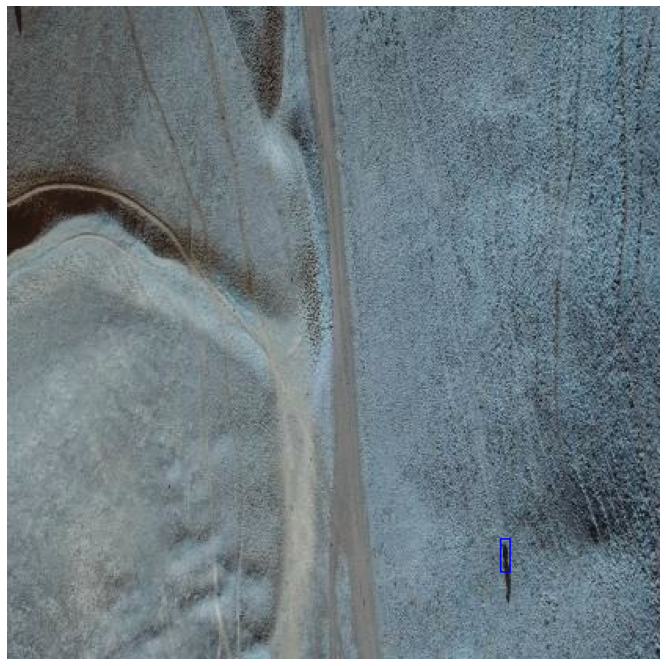


sample: DJI_0044_MOV-87_jpg.rf.55a18bd94348cbd63398887a465683dd
Number of labels in sample: 5


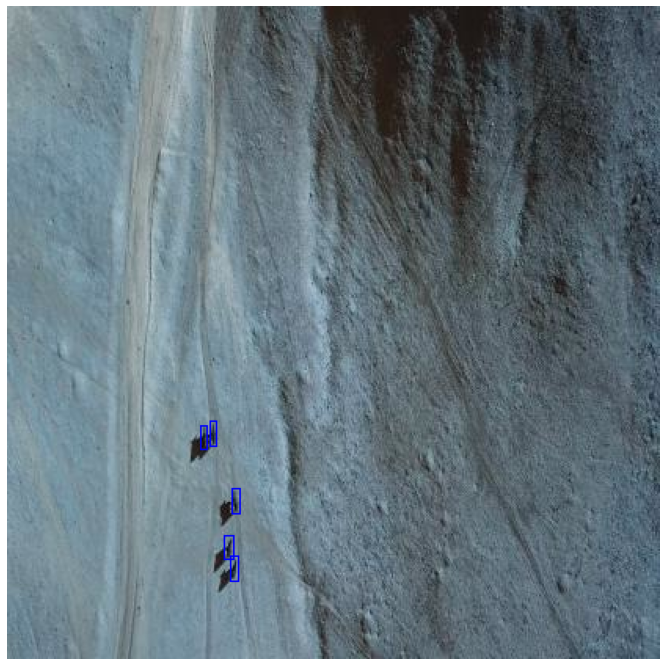


sample: DJI_0044_MOV-363_jpg.rf.11368abeb5d7a95a9dcc777a50aaae3a
Number of labels in sample: 0


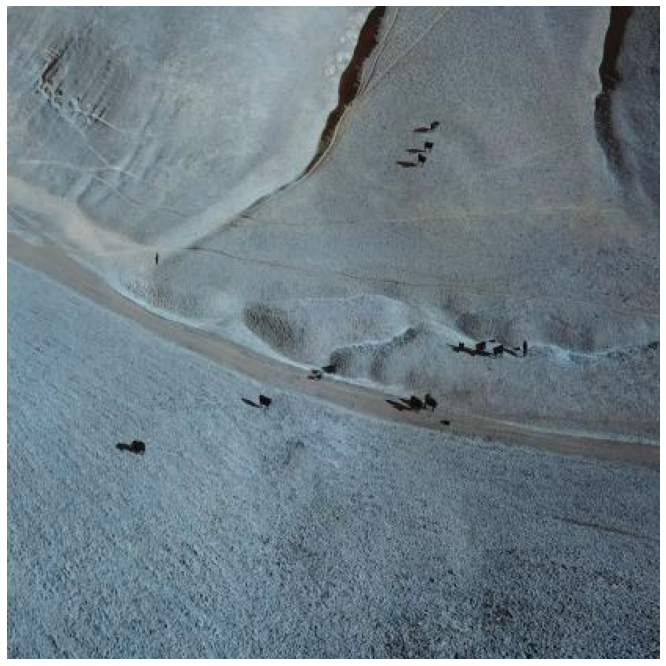


sample: DJI_0044_MOV-95_jpg.rf.4cd59953d245cc2505764b9c92f07d35
Number of labels in sample: 5


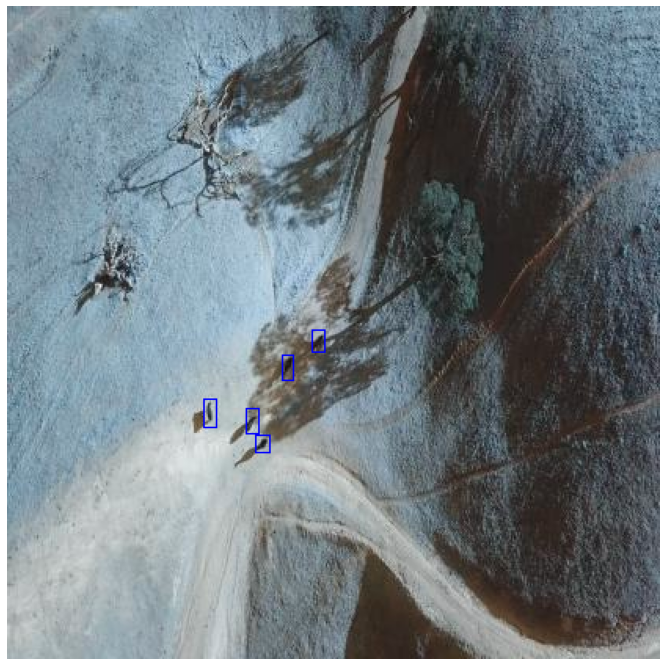


sample: DJI_0044_MOV-448_jpg.rf.33548629d15869749b3f24dfa902a78e
Number of labels in sample: 0


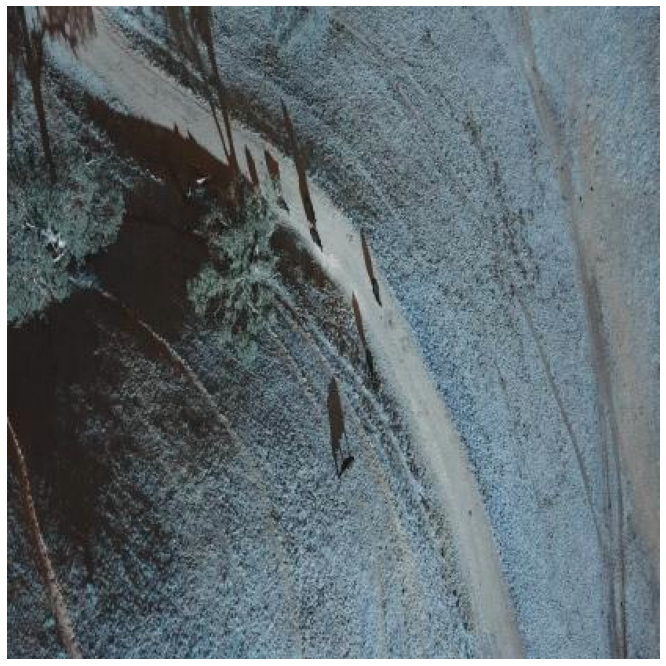

In [3]:
#extract a sample
def get_sample(idx):
    image,labels = train_dataset[idx]
    print(f'sample: {train_dataset.files[idx]}')
    print(f'Number of labels in sample: {len(labels)}')
    plot_image(image,labels)
    print()
    return

get_sample(50)
get_sample(140)
get_sample(200)
get_sample(450)
get_sample(500)

### The Yolov5 label format annotation: 

    .txt-file for each .jpg-image-file - in the same directory and with the same name, but with .txt-extension, and put to file: object number and object coordinates on this image, for each object in new line: <object-class> <x> <y> <width> <height>

    Where:

    <object-class> - integer number of object from 0 to (classes-1)
    <x> <y> <width> <height> - float values relative to width and height of image, it can be equal from (0.0 to 1.0]
    for example: <x> = <absolute_x> / <image_width> or <height> = <absolute_height> / <image_height>
    atention: <x> <y> - are center of rectangle (are not top-left corner)
    For example for img1.jpg you will be created img1.txt containing:

    1 0.716797 0.395833 0.216406 0.147222
    0 0.687109 0.379167 0.255469 0.158333
    1 0.420312 0.395833 0.140625 0.166667


source: [random post](https://github.com/AlexeyAB/Yolo_mark/issues/60)

Example:
![alt text](https://user-images.githubusercontent.com/26833433/91506361-c7965000-e886-11ea-8291-c72b98c25eec.jpg "Example for labeling format")